In [169]:
import quantecon as qe
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

# документация для ЦМ
# https://quanteconpy.readthedocs.io/en/stable/markov/core.html

# Оценка матрицы переходных вероятностей

Дана последовательность наблюдений

$X_1,X_2,…,X_N X_i \in E$.

Как подсчитать матрицу переходных вероятностей $p_{ij}=P(X_{n+1}=j|X_n=i)$?

**Закон больших чисел:**
Частота некоторого события в серии независимых испытаний приближается (и остается близкой) к его вероятности:

$\nu_n(A) \to P(A) (n \to \infty), \nu_n(A)= \dfrac{n_A}{n}$


$p_{ij}=P(X_{n+1}=j|X_n=i)\approx \dfrac{1}{N} \sum\limits_{n=1} I(X_{n+1}=j|X_n=i)$

In [170]:
P = ((0.971, 0.029, 0.000),
     (0.145, 0.778, 0.077),
     (0.000, 0.508, 0.492))

In [171]:
P = np.array(P)

In [172]:
P

array([[0.971, 0.029, 0.   ],
       [0.145, 0.778, 0.077],
       [0.   , 0.508, 0.492]])

In [173]:
mc1 = qe.MarkovChain(P)

In [174]:
# Метод генерирует цепь Маркова длиной 50 и любым начальным 
# состоянием 0
k=mc1.simulate(500000, init=0)

In [175]:
k

array([0, 0, 0, ..., 0, 0, 0])

In [176]:
def transition_matrix(transitions):
 n = 1+ max(transitions) #number of states

 M = [[0]*n for _ in range(n)]

 for (i,j) in zip(transitions,transitions[1:]):
  M[i][j] += 1

 #now convert to probabilities:
 for row in M:
  s = sum(row)
  if s > 0:
   row[:] = [f/s for f in row]
 return M

#test:

m = transition_matrix(k)
for row in m: print(' '.join('{0:.3f}'.format(x) for x in row))

0.971 0.029 0.000
0.145 0.779 0.077
0.000 0.503 0.497


In [177]:
print(P)

[[0.971 0.029 0.   ]
 [0.145 0.778 0.077]
 [0.    0.508 0.492]]


# Примеры решения задач

# Задача идентификации модели по последовательности состояний системы

In [178]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [179]:
with open('alice_en.txt', 'r') as f:
    text = f.read().lower()


In [180]:
text[:1000]

"project gutenberg's alice's adventures in wonderland, by lewis carroll\n\nthis ebook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  you may copy it, give it away or\nre-use it under the terms of the project gutenberg license included\nwith this ebook or online at www.gutenberg.org\n\n\ntitle: alice's adventures in wonderland\n\nauthor: lewis carroll\n\nposting date: june 25, 2008 [ebook #11]\nrelease date: march, 1994\n[last updated: december 20, 2011]\n\nlanguage: english\n\ncharacter set encoding: ascii\n\n*** start of this project gutenberg ebook alice's adventures in wonderland ***\n\n\n\n\n\n\n\n\n\n\nalice's adventures in wonderland\n\nlewis carroll\n\nthe millennium fulcrum edition 3.0\n\n\n\n\nchapter i. down the rabbit-hole\n\nalice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into the\nbook her sister was reading, but it had no pictures or conversat

In [181]:
text = re.sub('[^a-z]','', text)

In [182]:
text

'projectgutenbergsalicesadventuresinwonderlandbylewiscarrollthisebookisfortheuseofanyoneanywhereatnocostandwithalmostnorestrictionswhatsoeveryoumaycopyitgiveitawayorreuseitunderthetermsoftheprojectgutenberglicenseincludedwiththisebookoronlineatwwwgutenbergorgtitlealicesadventuresinwonderlandauthorlewiscarrollpostingdatejuneebookreleasedatemarchlastupdateddecemberlanguageenglishcharactersetencodingasciistartofthisprojectgutenbergebookalicesadventuresinwonderlandalicesadventuresinwonderlandlewiscarrollthemillenniumfulcrumeditionchapteridowntherabbitholealicewasbeginningtogetverytiredofsittingbyhersisteronthebankandofhavingnothingtodoonceortwiceshehadpeepedintothebookhersisterwasreadingbutithadnopicturesorconversationsinitandwhatistheuseofabookthoughtalicewithoutpicturesorconversationssoshewasconsideringinherownmindaswellasshecouldforthehotdaymadeherfeelverysleepyandstupidwhetherthepleasureofmakingadaisychainwouldbeworththetroubleofgettingupandpickingthedaisieswhensuddenlyawhiterabbitwith

In [183]:
# определим алфавит
ENGLISH = 'abcdefghijklmnopqrstuvwxyz'
# создадим словарь с ключами буквами и значениями - номерами от 0
POS = {l: i for i, l in enumerate(ENGLISH)}
POS


{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [184]:
# создадим пока матрицу из нолей, куда запишем вероятности переходов
probabilities = np.zeros((len(ENGLISH), len(ENGLISH)))


In [185]:

# бежим по символам (берем предыдущий и текущий)
for cp, cn in zip(text[:-1], text[1:]):
    # счетчик набегает по количеству встреченных переходов
    probabilities[POS[cp], POS[cn]] += 1

In [186]:
# имеем все тот же массим, но заполненный целыми числами
print(probabilities[0, 0])
print(probabilities[2, 18])
print(probabilities[20, 3])


11.0
2.0
104.0


In [187]:

# делим значения в столбцах матрицы на общее кол-во встреченных переходов от всех букв к рассмтариваемой
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

probabilities

array([[1.12187659e-03, 2.82508924e-02, 2.68230495e-02, 5.25242223e-02,
        2.03977562e-04, 1.11167772e-02, 2.65170831e-02, 4.89546150e-03,
        7.81234064e-02, 1.52983172e-03, 1.39724630e-02, 1.15961244e-01,
        2.50892402e-02, 1.83783784e-01, 6.11932687e-04, 1.87659357e-02,
        3.05966344e-04, 8.94441611e-02, 1.02804691e-01, 1.43192249e-01,
        8.66904640e-03, 2.12136665e-02, 1.30545640e-02, 1.22386537e-03,
        3.02906680e-02, 5.09943906e-04],
       [4.86827033e-02, 3.78006873e-02, 0.00000000e+00, 5.72737686e-04,
        3.72279496e-01, 0.00000000e+00, 0.00000000e+00, 5.72737686e-04,
        6.87285223e-02, 4.58190149e-03, 0.00000000e+00, 7.38831615e-02,
        5.72737686e-04, 1.14547537e-03, 1.32302405e-01, 1.71821306e-03,
        0.00000000e+00, 3.55097365e-02, 1.94730813e-02, 8.01832761e-03,
        1.38602520e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.55555556e-02, 0.00000000e+00],
       [1.20838881e-01, 6.65778961e-04, 1.19840213e-02

In [188]:

# получили массим, в котором указаны вероятности (количество благоприятных исходов ко всем исходам)
print(probabilities[0, 0])
print(probabilities[2, 18])
print(probabilities[20, 3])
print(probabilities.shape )

0.0011218765935747067
0.0006657789613848203
0.026143790849673203
(26, 26)


In [189]:
# переводим все это в датафрейм
df = pd.DataFrame(probabilities, index=(c for c in ENGLISH), columns=(c for c in ENGLISH))

In [190]:
df.head()

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
a,0.001122,0.028251,0.026823,0.052524,0.000204,0.011117,0.026517,0.004895,0.078123,0.001530,...,0.000306,0.089444,0.102805,0.143192,0.008669,0.021214,0.013055,0.001224,0.030291,0.000510
b,0.048683,0.037801,0.000000,0.000573,0.372279,0.000000,0.000000,0.000573,0.068729,0.004582,...,0.000000,0.035510,0.019473,0.008018,0.138603,0.000000,0.000000,0.000000,0.055556,0.000000
c,0.120839,0.000666,0.011984,0.002663,0.265646,0.000000,0.000000,0.169108,0.019640,0.000000,...,0.000000,0.041278,0.000666,0.078895,0.037617,0.000000,0.008988,0.000000,0.002663,0.000000
d,0.113163,0.032176,0.011883,0.027239,0.103473,0.018464,0.016088,0.033638,0.104022,0.002742,...,0.002559,0.027239,0.065082,0.159781,0.020841,0.009872,0.031627,0.000000,0.019561,0.000000
e,0.087609,0.017600,0.040785,0.087933,0.042213,0.022990,0.020782,0.022795,0.027731,0.003182,...,0.007079,0.148006,0.086115,0.070853,0.004156,0.015846,0.042408,0.007923,0.021301,0.000909


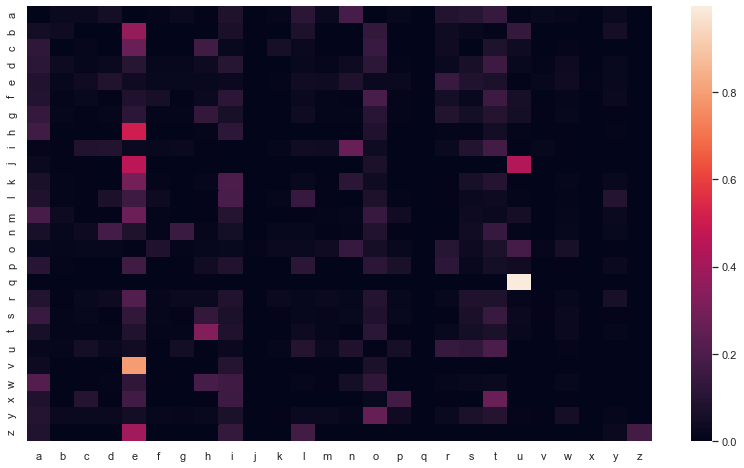

In [191]:
# строим тепловую карту. Высокое значение для последовательности 
#"qu". 
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

In [192]:

# Посчитаем вероятность начального состояния цепи для букв англ алфавита

In [193]:
with open('alice_en.txt', 'r') as f:
    text = f.read().lower()

In [194]:

# посчитаем число уникальных слов
len(set(text.split(' ')))

6964

In [195]:
# грубо прикинем для каждой буквы вероятность того, что с нее начинается случайное слово
unique_words = list(set(text.split(' ')))
unique_words[:10]

['',
 'shark,\n',
 'low\nvoice,',
 'file',
 'mallets',
 'one',
 'filled',
 'talk.',
 'pocket)',
 'rule']

In [196]:
# удалим первый элемент
del unique_words[0]

In [197]:

# посчитаем, сколько уникальных слов начинается на каждую букву
count_dict = {i:len(list(filter(lambda word: word[0] == i, unique_words))) for i in ENGLISH}
count_dict

{'a': 511,
 'b': 279,
 'c': 434,
 'd': 349,
 'e': 218,
 'f': 309,
 'g': 204,
 'h': 366,
 'i': 259,
 'j': 39,
 'k': 93,
 'l': 262,
 'm': 290,
 'n': 156,
 'o': 244,
 'p': 329,
 'q': 56,
 'r': 252,
 's': 672,
 't': 670,
 'u': 92,
 'v': 70,
 'w': 372,
 'x': 3,
 'y': 82,
 'z': 2}

In [198]:
# Можно проанализировать аномалии

In [199]:

# преобразуем значения в массив
prob_array =  np.array(list(count_dict.values()))
prob_array

array([511, 279, 434, 349, 218, 309, 204, 366, 259,  39,  93, 262, 290,
       156, 244, 329,  56, 252, 672, 670,  92,  70, 372,   3,  82,   2])

In [200]:
# чтобы посчитать вероятности
prob_array = prob_array / np.sum(prob_array)

In [201]:

prob_array

array([0.07727204, 0.04218963, 0.06562831, 0.05277484, 0.03296537,
       0.04672615, 0.03084833, 0.05534553, 0.03916528, 0.00589747,
       0.01406321, 0.03961893, 0.04385302, 0.0235899 , 0.03689702,
       0.04975049, 0.00846817, 0.03810676, 0.10161803, 0.10131559,
       0.01391199, 0.01058521, 0.05625284, 0.00045365, 0.01239982,
       0.00030243])

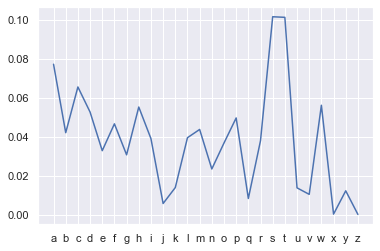

In [202]:

#Буква S - чемпион, с нее начинается больше всего слов (11% случаев)
x = [x for x in ENGLISH]
y = prob_array
plt.plot(x,y)

Теперь вопрос: допустим, что у нас есть какая-то траектория (последовательность состояний). Какова её вероятность? Ответ на этот вопрос дает теорема.

**Теорема о состояниях марковской цепи**

Для любого натурального $n$ и любых $i_0,i_1,…,i_{n−1},i,j$

$P(X_0=i_0,X_1=i_1,…,X_n=i_n)=α_{i_0}p_{i_0i_1}…p{i_{n−1}i_n}.$

Пример: Пусть вероятность начального состояния цепи для букв английского алфавита равна $\dfrac{1}{26}$.
Чему равна вероятность наблюдать строку "hello"?

In [203]:
string = "hello"
proba = 1.0 / 26
for cp, cn in zip(string[1:], string[:-1]):
    proba *= probabilities[POS[cp], POS[cn]]
print(proba)

5.348363016330027e-07


**Следствие.** Для любого натурального $n$ и любого $i_n \in E$

$P(X_n=i_n) = \sum \limits_{i_0,…,i_{n−1} \in E} \alpha i_0p_{i_0i_1}…p_{i_{n−1}i_n}$.

Но обычно нас не интересует полный путь, а лишь начало и конец. Поэтому вводят вероятность перейти из состояния $i$ в состояние $j$ за $n$ шагов:

$p_{ij}^{(n)}=P(X_n=j|X_0=i)$

Чему равна эта вероятность?

$P(X_n=j|X_0=i)=\dfrac{P(X_n=j,X_0=i)}{P(X_0=i)}=\sum \limits_{i_0,…,i_{n−1} \in E} \dfrac{P(X_0=i, X_1=i_1,...,X_{n-1}=i_{n-1}, X_n = j)}{P(X_0=i)}=\sum \limits_{i_0,…,i_{n−1} \in E} p_{ii_1}...p_{i_{n-1}j}$

Если мы посмотрим на случай $n=2$, то полученное выражение очень похоже на скалярное произведение строк матрицы переходной вероятности. Оказывается, что это не так уж и далеко от истины.

**Теорема.** Пусть $P^{(n)}=(p_{ij}^{(n)}) i,j \in E$. Тогда $P^{(n)}=P⋅P⋅…⋅P=P^n$

**Вопрос:** как подсчитать вероятность, что слово из 3 букв начинается на букву "h" и заканчивается на букву "y"?

In [204]:
start = POS['h']
end = POS['y']
prior = 1. / len(ENGLISH)
for c in ENGLISH:
    proba = prior * probabilities[start, POS[c]] * probabilities[POS[c], end]
    if proba > 0:
        print(''.join(['h', c, 'y']), proba)

hay 0.00019786241179454468
hby 3.2498131357446945e-06
hcy 2.5963886570530186e-07
hdy 2.00246712505073e-06
hey 0.00041670464060019366
hfy 2.4496387427496224e-06
hgy 2.2022341052346015e-07
hhy 3.0694052582470812e-06
hky 1.0202901705244971e-07
hly 6.987940162352581e-06
hmy 4.054691865351508e-06
hny 1.0187698076726042e-06
hoy 2.0758961455728112e-05
hpy 2.095534994542692e-06
hry 2.9097918521227684e-05
hsy 2.6301624264116166e-06
hty 2.5534949950507335e-05
huy 2.316043298098595e-07
hvy 3.0372085380791536e-08
hwy 6.902550257831721e-07
hyy 4.816238159185105e-06


Это работает не всегда. Почему же? Потому что никто не обещал, что переходная вероятность не зависит от шага. Если она действительно не зависит, то говорят, что марковская цепь однородна.

# Генерирование выборок из марковской цепи

Как создать реализацию длины $N$ из марковской цепи?
Сгенерировать начальное состояние согласно распределению $\alpha_i≡P(X_0=i)$, положить $n \leftarrow 0$.
Пока $n<N$, повторять:
- Имея контекст $X_n$, сгенерировать состояние $X_{n+1}$ из распределения $P(X_{n+1}|X_n)$
- Положить $n \leftarrow n+1$

In [205]:
s = []
start = np.random.choice(list(ENGLISH))
s.append(start)
length = 10
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(ENGLISH), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

qusetwilice


# Задача ранжирования

Тема, представляющая интерес для экономики и многих других дисциплин - рейтинг, ранжирование.



Рейтинг, присвоенный веб-страницам поисковыми системами.
(Хотя проблема мотивирована извне экономики, на самом деле существует тесная связь между системами ранжирования поиска и ценами в определенных конкурентных равновесиях - см. [[DLP13]] (https://python-programming.quantecon.org/zreferences. HTML # dlp2013))

Чтобы понять проблему, рассмотрите набор результатов, возвращаемых запросом к поисковой системе.

Для пользователя желательно получить большой набор точных совпадений
вернуть совпадения по порядку, где порядок соответствует некоторой мере «важности».
Ранжирование по степени важности является проблемой, которую мы сейчас рассматриваем.

Методология, разработанная для решения этой проблемы основателями Google Ларри Пейджем и Сергеем Брином известен как [PageRank] (https://en.wikipedia.org/wiki/PageRank).

Чтобы проиллюстрировать идею, рассмотрим следующую схему



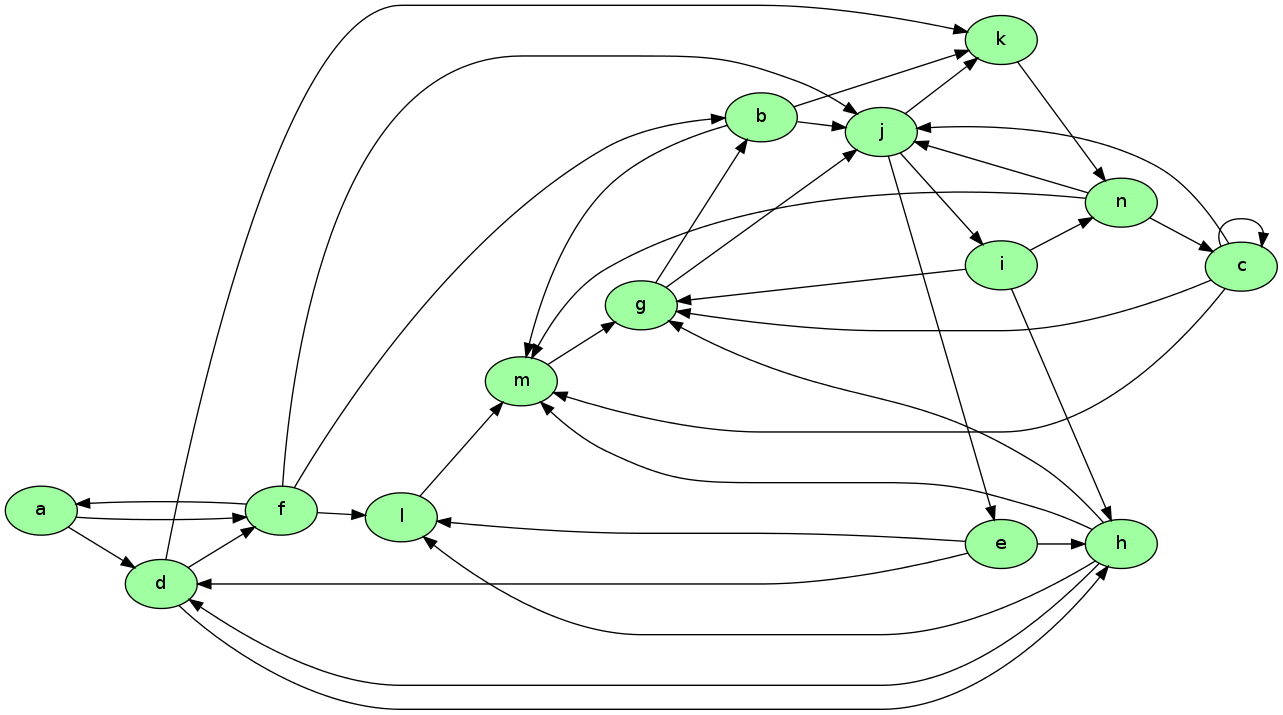

Представьте, что это миниатюрная версия WWW, с

- каждый узел, представляющий веб-страницу
- каждая стрелка, представляющая существование ссылки с одной страницы на другую


Теперь давайте подумаем о том, какие страницы могут быть важными в смысле ценности для пользователя поисковой системы.

Одним из возможных критериев важности страницы является количество входящих ссылок - показатель популярности.

По этой мере `m` и` j` являются наиболее важными страницами с 5 входящими ссылками каждая.

Однако что делать, если, скажем, страницы, ссылающиеся на `m`, сами по себе не важны?


Подумав так, представляется целесообразным взвешивать входящие узлы с относительной важностью.

Алгоритм  PageRank приблизительно выполняет следующий процесс. Мы считаем, что произвольный пользователь Интернета в исходный момент времени находится на одной из страниц. Затем этот пользователь начинает случайным образом начинает перемещаться, щёлкая на каждой странице по одной из ссылок, которые ведут на другую страницу рассматриваемого множества (предполагается, что все ссылки, ведущие вне этих страниц, запрещены). На любой странице все допустимые ссылки имеют одинаковую вероятность нажатия.

Так мы задаём цепь Маркова: страницы — это возможные состояния, переходные вероятности задаются ссылками со страницы на страницу (взвешенными таким образом, что на каждой странице все связанные страницы имеют одинаковую вероятность выбора), а свойства отсутствия памяти чётко определяются поведением пользователя. Если также предположить, что заданная цепь положительно возвратная и апериодичная (для удовлетворения этим требованиям применяются небольшие хитрости), тогда в длительной перспективе распределение вероятностей «текущей страницы» сходится к стационарному распределению. То есть какой бы ни была начальная страница, спустя длительное время каждая страница имеет вероятность (почти фиксированную) стать текущей, если мы выбираем случайный момент времени.

Несколько упрощенная презентация, которая отражает основную идею, заключается в следующем.



Обозначая  𝑗  (целочисленный индекс) типичной страницы, а  𝑟𝑗  ее рейтинг, мы устанавливаем


$$
r_j = \sum_{i \in L_j} \frac{r_i}{\ell_i}
$$

где

- $ \ell_i $ общее количество исходящих ссылок с $ i $  
- $ L_j $ это набор всех страниц $ i $ таких что $ i $ имеет ссылку на $ j $  



Это мера количества входящих ссылок, взвешенная по их собственному рейтингу (и нормализованная по $ 1 / \ell_i $).


Есть, однако, другая интерпретация, и она возвращает нас к цепям Маркова


Пусть  $ P $ марица, заданная  $ P(i, j) = \mathbf 1\{i \to j\} / \ell_i $ где $ \mathbf 1\{i \to j\} = 1 $ если $ i $ имеет сслыку на $ j $ и ноль в противном случае.

Матрица $ P $ 
является стохастической матрицей при условии, что каждая страница имеет хотя бы одну ссылку.

С этим определением $ P $ мы имеем
$$
r_j
= \sum_{i \in L_j} \frac{r_i}{\ell_i}
= \sum_{\text{all } i} \mathbf 1\{i \to j\} \frac{r_i}{\ell_i}
= \sum_{\text{all } i} P(i, j) r_i
$$



Записывая $ r $ для вектора строки ранжирования, это становится $ r = r P $.

Следовательно $ r $ является стационарным распределением стохастической матрицы $ P $.

Давайте подумаем о  $ P(i, j) $ как о вероятности «перехода» со страницы $ i $ на страницу $ j $.

Значение $ P(i, j) $ имеет интерпретацию

- $ P(i, j) = 1/k $ если $ i $ имеет $ k $ исходящие ссылки и $ j $ один из них 
- $ P(i, j) = 0 $ если $ i $ не имеет прямой ссылки на $ j $  


Таким образом, движение от страницы к странице - это движение веб-серфера, который перемещается с одной страницы на другую путем случайного нажатия на одну из ссылок на этой странице.

Здесь «случайный» означает, что каждая ссылка выбрана с равной вероятностью.

сторапниц $d$ тем важнее,

чем больше других документов $c$ ссылаются на $d$,
чем важнее документы $c$, ссылающиеся на $d$,
чем меньше других ссылок имеют эти документы $c$.


Поскольку $ r $ является стационарным распределением $ P $, редполагая, что условие равномерной эргодичности выполнено, мы  [можем интерпретировать](#new-interp-sd) $ r_j $ как долю времени, в течение которой (очень постоянное) случайное серфер проводит на странице $ j $.

В основе PageRank лежит такая гипотеза: наиболее вероятные страницы в стационарном распределении должны быть также и самыми важными (мы посещаем эти страницы часто, потому что они получают ссылки со страниц, которые в процессе переходов тоже часто посещаются). Тогда стационарное распределение вероятностей определяет для каждого состояния значение PageRank.

Одна из отличительных особенностей задачи ранжирования от классических задач машинного обучения заключается в том, что качество результата зависит не от предсказанных оценок релевантности, а от порядка следования документов в рамках конкретного запроса, т.е. важно не абсолютное значение релевантности (его достаточно трудно формализовать в виде числа), а то, более или менее релевантен документ, относительно других документов.



Задача - применить этот алгоритм ранжирования к графику, изображенному выше.
и вернуть список страниц, упорядоченных по рангу.

Всего имеется 14 узлов (то есть веб-страниц), первый из которых называется `a`, а последний -` n`.

Типичная строка из файла имеет вид

```text
d -> h;
```

Это следует интерпретировать как означающее, что существует ссылка от d до h.

Данные для этого графика показаны ниже и считываются в файл с именем web_graph_data.txt при выполнении ячейки.

In [206]:
%%file web_graph_data.txt
a -> d;
a -> f;
b -> j;
b -> k;
b -> m;
c -> c;
c -> g;
c -> j;
c -> m;
d -> f;
d -> h;
d -> k;
e -> d;
e -> h;
e -> l;
f -> a;
f -> b;
f -> j;
f -> l;
g -> b;
g -> j;
h -> d;
h -> g;
h -> l;
h -> m;
i -> g;
i -> h;
i -> n;
j -> e;
j -> i;
j -> k;
k -> n;
l -> m;
m -> g;
n -> c;
n -> j;
n -> m;

Overwriting web_graph_data.txt


Метод Таучена 

В качестве первого шага мы выбираем

- $ n $, число состояний для дискретного приближения
- $ m $, целое число, которое параметризует ширину пространства состояний


Затем мы создаем пространство состояний $ \{x_0, \ldots, x_{n-1}\} \subset \mathbb R $
и стохастическую $ n \times n $ матрицу $ P $ такую что

- $ x_0 = - m \, \sigma_y $  
- $ x_{n-1} = m \, \sigma_y $  
- $ x_{i+1} = x_i + s $,

где $ s = (x_{n-1} - x_0) / (n - 1) $  


Пусть $ F $ кумулятивная функция распределения нормального распределения $ N(0, \sigma_u^2) $.

Значения $ P(x_i, x_j) $ вычисляются для аппроксимации процесса AR (1) - без деривации правила следующие:

1. Если $ j = 0 $, то


$$
P(x_i, x_j) = P(x_i, x_0) = F(x_0-\rho x_i + s/2)
$$

1. Если $ j = n-1 $, то 


$$
P(x_i, x_j) = P(x_i, x_{n-1}) = 1 - F(x_{n-1} - \rho x_i - s/2)
$$

1. В противном случае 


$$
P(x_i, x_j) = F(x_j - \rho x_i + s/2) - F(x_j - \rho x_i - s/2)
$$


Упражнение заключается в написании функции `approx_markov(rho, sigma_u, m=3, n=7)` которая возвращает
$ \{x_0, \ldots, x_{n-1}\} \subset \mathbb R $ и $ n \times n $ матрицу
$ P $  как описано выше.


In [207]:

import numpy as np
from operator import itemgetter         

infile = 'web_graph_data.txt'              # ввод файла данных
alphabet = 'abcdefghijklmnopqrstuvwxyz'    # 

n = 14
Q = np.zeros((n, n), dtype=int)            # вернуть новый массив заданной формы и типа, заполненный нулями (матрица n на n)
f = open(infile, 'r')                      
edges = f.readlines()                      # возвращает список, содержащий строки файла;
f.close()                                  
for edge in edges:                          
    from_node, to_node = re.findall('\w', edge)    # перебрать строки файла: вернуть список всех совпадений за один шаг
    i, j = alphabet.index(from_node), alphabet.index(to_node)
    Q[i, j] = 1
P = np.empty((n, n))                      # вернуть новый массив заданной формы и типа, без инициализации записей
for i in range(n):
    P[i, :] = Q[i, :] / Q[i, :].sum()     # Построить P (i, j)
mc = qe.MarkovChain(P)
r = mc.stationary_distributions[0]
ranked_pages = {alphabet[i] : r[i] for i in range(n)}

print('Rankings\n ***')                   # сортируем полученный список
for name, rank in sorted(ranked_pages.items(), key=itemgetter(1), reverse=1):
    print (f'{name}: {rank:.4}')

Rankings
 ***
g: 0.1607
j: 0.1594
m: 0.1195
n: 0.1088
k: 0.09106
b: 0.08326
e: 0.05312
i: 0.05312
c: 0.04834
h: 0.0456
l: 0.03202
d: 0.03056
f: 0.01164
a: 0.002911


# НOMEWORK

Задача 1:
Для русской версии книги Алиса в стране чудес постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов

In [208]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [209]:
import codecs
file = codecs.open("alice_ru.txt", "r", "utf-8" )
ru_text = file.read()

In [210]:
ru_text[:1000]

"Июльский полдень золотой\n    Сияет так светло,\n    В неловких маленьких руках\n    Упрямится весло,\n    И нас теченьем далеко\n    От дома унесло.\n\n    Безжалостные! В жаркий день,\n    В такой сонливый час,\n    Когда бы только подремать,\n    Не размыкая глаз,\n    Вы требуете, чтобы я\n    Придумывал рассказ.\n\n    И Первая велит начать\n    Его без промедленья,\n    Вторая просит: ``Поглупей\n    Пусть будут приключенья''.\n    А Третья прерывает нас\n    Сто раз в одно мгновенье.\n\n    Но вот настала тишина,\n    И, будто бы во сне,\n    Неслышно девочка идет\n    По сказочной стране\n    И видит множество чудес\n    В подземной глубине.\n\n    Но ключ фантазии иссяк --\n    Не бьет его струя.\n    -- Конец я после расскажу,\n    Даю вам слово я!\n    -- Настало после! -- мне кричит\n    Компания моя.\n\n    И тянется неспешно нить\n    Моей волшебной сказки,\n    К закату дело, наконец,\n    Доходит до развязки.\n    Идем домой. Вечерний луч\n    Смягчил дневные краски.\n

In [211]:
ru_text = re.sub('[^а-я]','', ru_text)

In [212]:
ru_text

'юльскийполденьзолотойияеттаксветлонеловкихмаленькихрукахпрямитсявеслонастеченьемдалекотдомаунеслоезжалостныежаркийденьтакойсонливыйчасогдабытолькоподрематьеразмыкаяглазытребуетечтобыяридумывалрассказерваявелитначатьгобезпромедленьятораяпроситоглупейустьбудутприключеньяретьяпрерываетнасторазводномгновеньеовотнасталатишинабудтобывоснееслышнодевочкаидетосказочнойстраневидитмножествочудесподземнойглубинеоключфантазиииссякебьетегоструяонецяпослерасскажуаювамсловояасталопослемнекричитомпаниямоятянетсянеспешнонитьоейволшебнойсказкизакатуделонаконецоходитдоразвязкидемдомойечернийлучмягчилдневныекраскилисасказкудетскихднейранидосединытомтайникегдетыхранишьладенческиесныакстранникбережетцветокалекойсторонылавалисенаскучилосидетьссестройбезделанаберегурекиразокдругойоназаглянулавкнижкукоторуючиталасестранотамнебылоникартинокниразговоровтотолкувкнижкеподумалалисаесливнейнетникартинокниразговоровнасиделаиразмышляланевстатьлиейиненарватьлицветовдлявенкамыслиеетеклимедленноинесвязноотжарыееклониловс

In [213]:
# определим алфавит
RUSSIA = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
# создадим словарь с ключами буквами и значениями - номерами от 0
POS = {l: i for i, l in enumerate(RUSSIA)}
POS

{'а': 0,
 'б': 1,
 'в': 2,
 'г': 3,
 'д': 4,
 'е': 5,
 'ё': 6,
 'ж': 7,
 'з': 8,
 'и': 9,
 'й': 10,
 'к': 11,
 'л': 12,
 'м': 13,
 'н': 14,
 'о': 15,
 'п': 16,
 'р': 17,
 'с': 18,
 'т': 19,
 'у': 20,
 'ф': 21,
 'х': 22,
 'ц': 23,
 'ч': 24,
 'ш': 25,
 'щ': 26,
 'ъ': 27,
 'ы': 28,
 'ь': 29,
 'э': 30,
 'ю': 31,
 'я': 32}

In [214]:
# создадим пока матрицу из нолей, куда запишем вероятности переходов
probabilities = np.zeros((len(RUSSIA), len(RUSSIA)))

In [215]:
# бежим по символам (берем предыдущий и текущий)
for cp, cn in zip(ru_text[:-1], ru_text[1:]):
    # счетчик набегает по количеству встреченных переходов
    probabilities[POS[cp], POS[cn]] += 1

In [216]:
# имеем все тот же массим, но заполненный целыми числами
print(probabilities[0, 0])
print(probabilities[2, 18])
print(probabilities[20, 3])

97.0
434.0
170.0


In [217]:
# делим значения в столбцах матрицы на общее кол-во встреченных переходов от всех букв к рассмтариваемой
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

probabilities

/Users/irinaskripka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([[0.01032684, 0.01277547, 0.05567976, ..., 0.00404557, 0.011285  ,
        0.02757373],
       [0.05409357, 0.00146199, 0.00365497, ..., 0.00584795, 0.        ,
        0.0504386 ],
       [0.19212772, 0.00137627, 0.00853289, ..., 0.00330306, 0.        ,
        0.00522984],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01631702, 0.07459207, 0.03962704, ..., 0.00699301, 0.004662  ,
        0.002331  ],
       [0.01901566, 0.0212528 , 0.06040268, ..., 0.00894855, 0.0033557 ,
        0.0139821 ]])

In [218]:
# получили массим, в котором указаны вероятности (количество благоприятных исходов ко всем исходам)
print(probabilities[0, 0])
print(probabilities[2, 18])
print(probabilities[20, 3])
print(probabilities.shape )

0.010326839135526455
0.11946050096339114
0.06004945249028612
(33, 33)


In [219]:
#переводим все это в датафрейм
df = pd.DataFrame(probabilities, index=(c for c in RUSSIA), columns=(c for c in RUSSIA))
df.head()

,а,б,в,г,д,е,ё,ж,з,и,...,ц,ч,ш,щ,ъ,ы,ь,э,ю,я
а,0.010327,0.012775,0.055680,0.011604,0.039285,0.029703,0.0,0.015650,0.074098,0.019802,...,0.000639,0.026296,0.010859,0.003939,0.000000,0.003300,0.000000,0.004046,0.011285,0.027574
б,0.054094,0.001462,0.003655,0.000000,0.002924,0.151316,0.0,0.000731,0.000000,0.071637,...,0.000000,0.000000,0.000000,0.006579,0.012427,0.271930,0.003655,0.005848,0.000000,0.050439
в,0.192128,0.001376,0.008533,0.006056,0.019543,0.132397,0.0,0.001376,0.020919,0.082026,...,0.000826,0.005780,0.012386,0.000000,0.000000,0.057253,0.004129,0.003303,0.000000,0.005230
г,0.059645,0.003173,0.005711,0.000000,0.085025,0.008249,0.0,0.000000,0.003173,0.053299,...,0.000635,0.004442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000635
д,0.173262,0.004226,0.033039,0.001537,0.004226,0.187476,0.0,0.000000,0.002689,0.074529,...,0.010373,0.001153,0.000000,0.000000,0.000000,0.024203,0.020361,0.000384,0.002305,0.012294


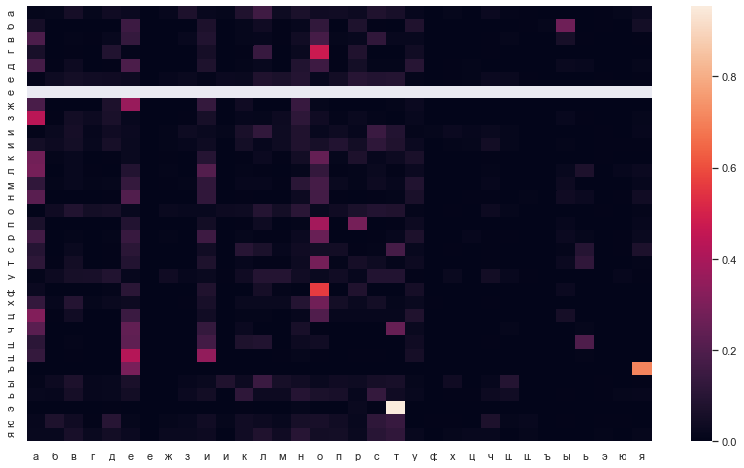

In [220]:
# строим тепловую карту. Высокое значение для последовательности 
#"qu". 
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

In [221]:
# Посчитаем вероятность начального состояния цепи для букв англ алфавита

In [222]:
import codecs
file = codecs.open("alice_ru.txt", "r", "utf-8" )
ru_text = file.read()

In [223]:
# посчитаем число уникальных слов
len(set(ru_text.split(' ')))

8083

In [224]:
# грубо прикинем для каждой буквы вероятность того, что с нее начинается случайное слово
unique_words = list(set(ru_text.split(' ')))
unique_words[:10]

['',
 'но\nего',
 'правду).--Девочки,',
 'Стоит',
 'ним,',
 'кончит,',
 'банку',
 'Присужу\n',
 'продолжала:\n\n',
 'подрастешь,']

In [225]:
# удалим первый элемент
del unique_words[0]

In [226]:
# посчитаем, сколько уникальных слов начинается на каждую букву
count_dict = {i:len(list(filter(lambda word: word[0] == i, unique_words))) for i in RUSSIA}
count_dict

{'а': 25,
 'б': 215,
 'в': 539,
 'г': 201,
 'д': 344,
 'е': 75,
 'ё': 0,
 'ж': 65,
 'з': 278,
 'и': 187,
 'й': 0,
 'к': 377,
 'л': 131,
 'м': 287,
 'н': 497,
 'о': 395,
 'п': 1003,
 'р': 254,
 'с': 769,
 'т': 286,
 'у': 263,
 'ф': 28,
 'х': 74,
 'ц': 22,
 'ч': 134,
 'ш': 66,
 'щ': 6,
 'ъ': 0,
 'ы': 0,
 'ь': 0,
 'э': 41,
 'ю': 6,
 'я': 45}

In [227]:
# Можно проанализировать аномалии

In [228]:
# преобразуем значения в массив
prob_array =  np.array(list(count_dict.values()))
prob_array

array([  25,  215,  539,  201,  344,   75,    0,   65,  278,  187,    0,
        377,  131,  287,  497,  395, 1003,  254,  769,  286,  263,   28,
         74,   22,  134,   66,    6,    0,    0,    0,   41,    6,   45])

In [229]:
# чтобы посчитать вероятности
prob_array = prob_array / np.sum(prob_array)

In [230]:
prob_array

array([0.00378043, 0.03251172, 0.08150612, 0.03039468, 0.05201875,
       0.0113413 , 0.        , 0.00982912, 0.04203841, 0.02827763,
       0.        , 0.05700892, 0.01980947, 0.04339936, 0.075155  ,
       0.05973083, 0.15167095, 0.03840919, 0.1162861 , 0.04324815,
       0.03977015, 0.00423408, 0.01119008, 0.00332678, 0.02026312,
       0.00998034, 0.0009073 , 0.        , 0.        , 0.        ,
       0.00619991, 0.0009073 , 0.00680478])

In [231]:
max(prob_array)

0.15167095115681234

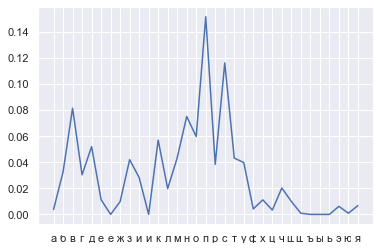

In [232]:
#Буква п - чемпион, с нее начинается больше всего слов (14% случаев)
x = [x for x in RUSSIA]
y = prob_array
plt.plot(x,y)

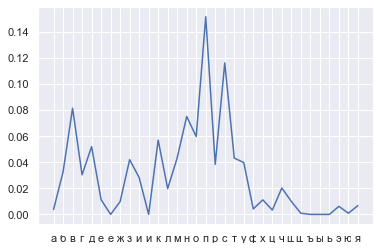

In [233]:
x = [x for x in RUSSIA]
y = prob_array
plt.plot(x,y)

Подсчитаем вероятность, что слово из 4-х символов, которая начинается п, а кончается на р

In [234]:
start = POS['п']
end = POS['р']
prior = 1. / len(RUSSIA)
for c in RUSSIA:
    proba = prior * probabilities[start, POS[c]] * probabilities[POS[c], end]
    if proba > 0:
        print(''.join(['п', c, c, 'р']), proba)

паар 6.303535867199167e-05
пггр 9.469962128636573e-07
пеер 0.00026260047741774026
пиир 2.5128535766833643e-05
пккр 8.744987024343406e-06
пллр 9.063659636775301e-06
пммр 1.0664799900092156e-07
пннр 7.523721635992642e-07
поор 0.0007939363476412567
пппр 6.840175286877611e-06
пррр 8.747979278455721e-06
псср 1.0780793003869066e-07
пттр 1.1678017501745862e-05
пуур 1.6325923017541397e-05
пццр 5.611360536086939e-07
пщщр 4.7950715870622446e-08
пыыр 1.588417062140715e-05
пььр 4.296493120907478e-07
пяяр 1.0657609781794655e-05


Это работает не всегда. Почему же? Потому что никто не обещал, что переходная вероятность не зависит от шага. Если она действительно не зависит, то говорят, что марковская цепь однородна.

In [235]:
#Генерирование выборок из марковской цепи
#Используя матрицу переходных вероятностей 
#сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов
s = []
start ='б'
s.append(start)
length = 8
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIA), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

быпонаска


Задача 2: проранжировать страницы сайта
    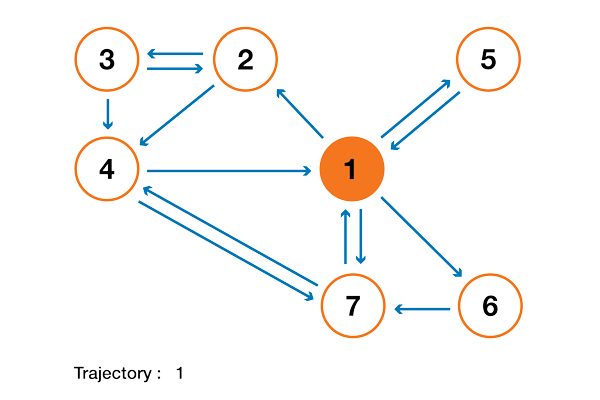

Пооверка: 1 > 7 > 4 > 2 > 5 = 6 > 3.

In [236]:
%%file web_graph_data_2.txt
1 -> 7;
7 -> 1;
1 -> 6;
6 -> 7;
7 -> 4;
4 -> 7;
4 -> 1;
3 -> 4;
2 -> 4;
2 -> 3;
3 -> 2;
1 -> 2;
4 -> 1;
1 -> 5;
5 -> 1;

Overwriting web_graph_data_2.txt


In [237]:
import numpy as np
from operator import itemgetter         

infile = 'web_graph_data_2.txt'              # ввод файла данных
alphabet = '1234567'    # 

n = 7
Q = np.zeros((n, n), dtype=int)            # вернуть новый массив заданной формы и типа, заполненный нулями (матрица n на n)
f = open(infile, 'r')                      
edges = f.readlines()                      # возвращает список, содержащий строки файла;
f.close()                                  
for edge in edges:                          
    from_node, to_node = re.findall('\w', edge)    # перебрать строки файла: вернуть список всех совпадений за один шаг
    i, j = alphabet.index(from_node), alphabet.index(to_node)
    Q[i, j] = 1
P = np.empty((n, n))                      # вернуть новый массив заданной формы и типа, без инициализации записей
for i in range(n):
    P[i, :] = Q[i, :] / Q[i, :].sum()     # Построить P (i, j)
mc = qe.MarkovChain(P)
r = mc.stationary_distributions[0]
ranked_pages = {alphabet[i] : r[i] for i in range(n)}

print('Rankings\n ***')                   # сортируем полученный список
for name, rank in sorted(ranked_pages.items(), key=itemgetter(1), reverse=1):
    print (f'{name}: {rank:.4}')

Rankings
 ***
1: 0.2857
7: 0.2381
4: 0.1905
2: 0.09524
5: 0.07143
6: 0.07143
3: 0.04762
